In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [138]:
from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split

# house_prices = load_boston()
# X, y = house_prices.data, house_prices.target

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

n_train = 10
n_test = X.shape[0] - n_train

# normalize X
#X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True) 

# low rank approximation of X
# rank = np.linalg.matrix_rank(X)
# u, s, vh = np.linalg.svd(X)
# X = u[:,:rank].dot(np.diag(s)[:rank,:rank]).dot(vh[:rank,:])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)

# train theta
lambda_ = 0
theta = np.linalg.inv(X_train.T.dot(X_train)+lambda_*np.eye(X_train.shape[1])).dot(X_train.T.dot(y_train))

# test
y_pred = X_test.dot(theta)

# evaluate performance
print('MSE on Training Data: {:0.3f}'.format(np.sum((X_train.dot(theta) - y_train)**2)/y_train.size))
print('MSE on Test Data: {:0.3f}'.format(np.sum((y_pred - y_test)**2)/y_test.size))



MSE on Training Data: 0.000
MSE on Test Data: 99036.313


### Problem 1: Implementing Ordinary Least Squares Regression

You are provided a class template called `MyLeastSquares` to implement your very own least squares class below. You are required to fill in the `fit` and `predict()` methods of the class. Make sure that the functions are able to take in inputs and return outputs of the shape specified in the function definitions. Run the cell after you complete this to train and predict your regressor on the diabetes dataset provided by the sklearn library. If everything goes right, you should see training and test errors in the range $1000$ to $5000$. Use the normal equation method of solving regression problems as described in the lecture slides. *Do not forget to account for the intercept term!* (**_Hint:_** It may be helpful to look into `numpy.linalg.inv` and `numpy.matmul` functions.)

In [64]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

class MyLeastSquares:
    def __init__(self, X_train, y_train):
        """Function stores feature matrix and corresponding target data.
        
        Parameters:
        -----------
        X_train: array_like, shape(N,D)
            ndarray containing N training examples, each with D feature values.
            
        y_train: array_like, shape(N,1)
            ndarray containing target values for each of N examples in X_train."""
        
        self.X_train = X_train
        self.y_train = y_train
        
    def fit(self):
        """Function computes the weight vector of shape (D+1, 1) for regression"""
        # append ones for bias
        X = np.concatenate((self.X_train, np.ones((self.X_train.shape[0],1))), axis=1)
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(self.y_train))

    def predict(self, X_test):
        """Function predicts targets for given X_test.
        
        Parameters:
        -----------
        X_test: array_like, shape(N,D)
            ndarray containing N test examples with D features each.
            
        Returns: array_like, shape(N,1).
            ndarray containing predicted targets of shape (N,1).
        """
        
        X = np.concatenate((X_test, np.ones((X_test.shape[0],1))), axis=1)
        y_pred = X.dot(self.theta)
        
        return y_pred
    
# load dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# train-test split
n_train = 40
n_test = X.shape[0] - n_train

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)

# train theta
LS = MyLeastSquares(X_train, y_train)
LS.fit()

# test
y_pred = LS.predict(X_test)

# evaluate performance
print('MSE on Training Data: {:0.3f}'.format(np.sum((LS.predict(X_train) - y_train)**2)/y_train.size))
print('MSE on Test Data: {:0.3f}'.format(np.sum((y_pred - y_test)**2)/y_pred.size))



MSE on Training Data: 3203.340
MSE on Test Data: 3282.631


### Problem 2: Singular Value Decomposition and Least Squares

A problem that can sometimes happen with regression methods is collinearity of features (i.e., some features are linear combinations of other features.) This results in an ill-conditioned data matrix $X$ which can in turn lead to unstable solutions or even singular matrices (with no inverse). The underlying cause of this instability is the very small (or even zero-valued) singular values in the singular value decomposition (SVD) of the data matrix $X$, stemming from the fact that one or more of its columns happen to be linear combinations of the rest. A potential solution around this problem is to then reconstruct $X$ via a low rank matrix approximation,$\hat{X}$, using only the largest singular values in the original SVD of X. This leads to a more stable solution for the regression algorithm than if used with the original $X$. 

For an $N\times D$ matrix $X$ and a corresponding $N\times 1$, the least squares formulation may be stated as:

\begin{equation}
X\mathbf{\theta} = \mathbf{y}, \tag{1}
\end{equation}

where $\theta$ is a $D\times 1$ parameter vector. The SVD for $X$ may then be substituted as follows:

\begin{equation}
U\Sigma V^{T}\mathbf{\theta} = \mathbf{y}, \tag{2}
\end{equation}

where $U$ is an $N\times N$ orthogonal matrix (containing the left singular vectors), $\Sigma$ is an $N\times D$ matrix (containing the singular values on its main diagonal and zeros elsewhere), and $V$ is an $D\times D$ orthogonal matrix (containing the right singular vectors). An $r$-rank approximation of $X$ is given as follows:

\begin{equation}
\hat{X}_{r} = U(:,:r)\times\Sigma(:r,:r)\times V(:r,:) \tag{3}
\end{equation}

Replacing $X$ by $\hat{X}_{r}$ in Equation 2 followed by the inverse, we obtain the following solution for theta:

\begin{align}
\hat{U}_{r}\hat{\Sigma}_{r}\hat{V}_{r}^{T}\mathbf{\theta} &= \mathbf{y}, \tag{4} \\
\mathbf{\hat{\theta}} &= \hat{V}_{r}\hat{\Sigma}_{r}^{-1}\hat{U}_{r}^{T}\mathbf{y}. \tag{5}
\end{align}


You are provided below the Boston House prices Dataset each training examples for which originally contained 13 features. We changed the data to replace one of those features to be a simple linear combination of the others, resulting in a rank-deficient data matrix X. For this question, perform the following:

**(a)** For the class `MySVDLeastSquares` given below, implement the `fit()` and `predict()` methods as before. In particular, the `fit()` method computes the $\theta$ vector via a low rank approximation of $X$ as depicted in Equation 5 above, with the rank provided by the user. *Don't forget to account for the intercept term in the $\theta$ vector!* (**_Hint:_** It may be helpful to look into `numpy.linalg.svd` and `numpy.linalg.matrix_rank` functions.)

**(b)** Run the cell underneath to perform a stability analysis of SVD-based least squares method to target values containing random noise. What do you observe? Describe and explain with reference to the underlying phenomena.

In [1551]:
# for part (a)

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

    
class MySVDLeastSquares:
    def __init__(self, X_train, y_train):
        """Function stores feature matrix and corresponding target data.
        
        Parameters:
        -----------
        X_train: array_like, shape(N,D)
            ndarray containing N training examples, each with D feature values.
            
        y_train: array_like, shape(N,1)
            ndarray containing target values for each of N examples in X_train."""
        
        self.X_train = X_train
        self.y_train = y_train
        
    def fit(self, rank):
        """Function computes the weight vector of shape (D+1, 1) for regression via a low rank approximation
        with given rank"""
        
        # append ones for bias
        X = np.concatenate((self.X_train, np.ones((self.X_train.shape[0],1))), axis=1)
        u, s, vh = np.linalg.svd(X) 
        rank = rank
        self.theta = vh.T[:,:rank].dot(np.diag(1/s)[:rank,:rank]).dot(u.T[:rank,:]).dot(self.y_train.reshape(-1,1))

    def predict(self, X_test):
        """Function predicts targets for given X_test.
        
        Parameters:
        -----------
        X_test: array_like, shape(N,D)
            ndarray containing N test examples with D features each.
            
        Returns: array_like, shape(N,1).
            ndarray containing predicted targets of shape (N,1).
        """
        
        X = np.concatenate((X_test, np.ones((X_test.shape[0],1))), axis=1)
        y_pred = X.dot(self.theta)
        
        return y_pred    
    
# load dataset
house_prices = load_boston()
X, y = house_prices.data, house_prices.target
X[:,[-1]] = np.sum(X[:,:-1],axis=1,keepdims=True) 

# train-test split
n_train = 30
n_test = X.shape[0] - n_train

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)

# train theta
LS = MySVDLeastSquares(X_train, y_train)
LS.fit(rank=14)

# # test
y_pred = LS.predict(X_test)

# evaluate performance
print('MSE on Training Data: {:0.3f}'.format(np.sum((X_train.dot(theta) - y_train)**2)/y_train.size))
print('MSE on Test Data: {:0.3f}'.format(np.sum((y_pred - y_test)**2)/y_pred.size))



MSE on Training Data: 3311.049
MSE on Test Data: 91181.267


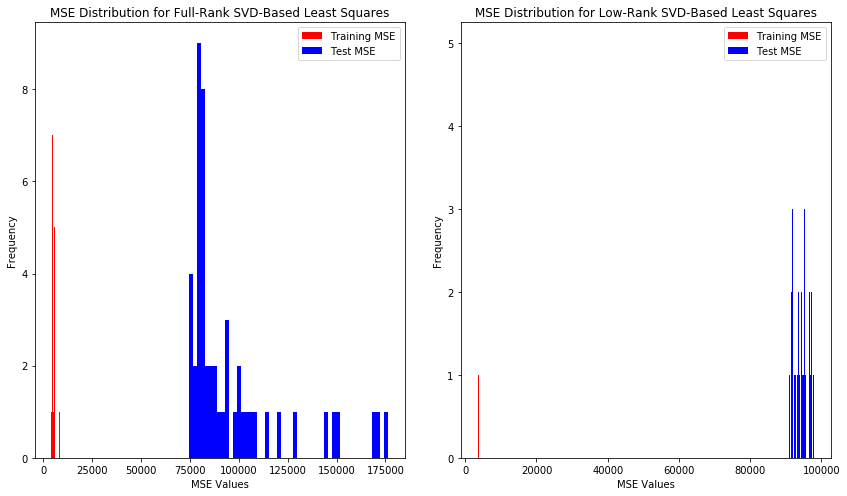

In [1567]:
# for part (b)

import matplotlib.pyplot as plt

# load dataset
house_prices = load_boston()
X, y = house_prices.data, house_prices.target
X[:,[-1]] = np.sum(X[:,:-1],axis=1,keepdims=True) 

# train-test split
n_train = 30
n_test = X.shape[0] - n_train

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))

num_trials = 50  # fix number of trials for each experiment

# full rank approximation of X
mse_train = []  # array to collect mses for training set
mse_test = []  # array to collect mses for training set
for i in range(num_trials):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)
    
    # add noise to y_train
    y_train += 0.1*np.random.normal(y_train.mean(), 0.5*y_train.std(), size=y_train.shape)
    
    # train theta
    LS = MySVDLeastSquares(X_train, y_train)
    LS.fit(rank=14)

    # test
    y_pred = LS.predict(X_test)
    
    mse_train.append(np.sum((LS.predict(X_train) - y_train)**2)/y_train.size)  # store mse train
    mse_test.append(np.sum((LS.predict(X_test) - y_train)**2)/y_train.size)  # store mse test
   
ax1.hist(mse_train, bins = 50, color='r', label='Training MSE')
ax1.hist(mse_test, bins = 50, color='b', label='Test MSE')
ax1.set_title('MSE Distribution for Full-Rank SVD-Based Least Squares')
ax1.set_xlabel('MSE Values')
ax1.set_ylabel('Frequency')
ax1.legend()

# low rank approximation of X
mse_train = []  # array to collect mses for training set
mse_test = []  # array to collect mses for training set
for i in range(num_trials):
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)
    
    # add noise to y_train
    y_train += 0.1*np.random.normal(y_train.mean(), 0.5*y_train.std(), size=y_train.shape)
    
    # train theta
    LS = MySVDLeastSquares(X_train, y_train)
    LS.fit(rank=7)

    # test
    y_pred = LS.predict(X_test)
    
    mse_train.append(np.sum((LS.predict(X_train) - y_train)**2)/y_train.size)  # store mse train
    mse_test.append(np.sum((LS.predict(X_test) - y_train)**2)/y_train.size)  # store mse test

    
ax2.hist(mse_train, bins = 50, color='r', label='Training MSE')
ax2.hist(mse_test, bins = 50, color='b', label='Test MSE')
ax2.set_title('MSE Distribution for Low-Rank SVD-Based Least Squares')
ax2.set_xlabel('MSE Values')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()

**_Solution to (b)_**

It is observed that the MSEs for both test and train sets show a much greater scatter with full rank SVD-based least squares method compared to the low rank version. It shows that the latter is more robust to noises in target data corresponding to ill-conditioned data matrices with collinear features. The reason may be states as follows:

The full rank version of Equation 5 may be rewritten as:

\begin{align}
\mathbf{\hat{\theta}} &= \sum^{D}_{i=1} \frac{\mathbf{v}_{i}\mathbf{u}_{i}^{T}\mathbf{y}}{\sigma_{i}}  \tag{6}
\end{align}

Small values of $\sigma$ in the denominaor introduce large multiples in the numerator, translating small disturbances in $\mathbf{y}$ to much induce much larger effect. THe low-rank approximation is thus a way to regularize ill-conditioned matrices and overcome overfitting in small datasets. 

### Problem 3: Regularizing Regression via the Ridge Penalty

Another method commonly used in many machine learning approaches to regularize limited labeled data problems and prevent overfitting is that of Ridge Regression. Ridge Least Squares, as you studied in class, introduced an L-2 norm penalty to the cost function. Among other things, this leads to the regression algorithm trying to find a parameter weight vector with less overall magnitude in hopes that it would prevent the algorithm to overfit on any one feature of the data. The weight applied to the ridge penalty is something prespecified by the user.

**_(a)_** In the code cell below, you are provided a class template called `MyRidgeLeastSquares`. Complete the `fit()` and `predict()` methods as before to train a regression algorithm for the diabetes dataset in sklearn. Use the normal solution method provide in the slides. *Don't forget to account for the intercept term in the $\theta$ vector!*

**_(b)_** As in Problem 2, you are now required to use this class and practice with various values of the ridge penalty weight $\alpha$. What happens when it is too low? Too high? Select a value for $\alpha$ that works the best for you. Now taking this value, perform a robustness analysis to various amounts of training data quantities (e.g., $5, 10, 20, 50$ etc.) for the Ridge Loss. For each of those quantities, also train and report the results for the naive Least Squares algorithm you implemented in problem 1. How does the performance compare for both? For high data quantities? For low data quantities? Provide a comprehensive answer. Bonus points will be given if the answer is accompanied by clear, good-looking plots for these analysis. You are encouraged to write your own code for the analysis part. 


In [1596]:
# for part (a)

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

class MyRidgeLeastSquares:
    def __init__(self, X_train, y_train, alpha=0):
        """Function stores feature matrix and corresponding target data.
        
        Parameters:
        -----------
        X_train: array_like, shape(N,D)
            ndarray containing N training examples, each with D feature values.
            
        y_train: array_like, shape(N,1)
            ndarray containing target values for each of N examples in X_train.
        
        alpha: float
            float specifying the multiplier of the L2 penalty in Ridge loss"""
        
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha
        
    def fit(self):
        """Function computes the weight vector of shape (D+1, 1) for regression"""
        # append ones for bias
        X = np.concatenate((self.X_train, np.ones((self.X_train.shape[0],1))), axis=1)
        self.theta = np.linalg.inv(X.T.dot(X) + self.alpha*np.eye(X.shape[1])).dot(X.T.dot(self.y_train))
     
    def predict(self, X_test):
        """Function predicts targets for given X_test.
        
        Parameters:
        -----------
        X_test: array_like, shape(N,D)
            ndarray containing N test examples with D features each.
            
        Returns: array_like, shape(N,1).
            ndarray containing predicted targets of shape (N,1).
        """
        
        X = np.concatenate((X_test, np.ones((X_test.shape[0],1))), axis=1)
        y_pred = X.dot(self.theta)
        
        return y_pred
    
# load dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# train-test split
n_train = 80
n_test = X.shape[0] - n_train

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test)

# train theta
LS = MyRidgeLeastSquares(X_train, y_train, alpha=2)
LS.fit()

# test
y_pred = LS.predict(X_test)

# evaluate performance
print('MSE on Training Data: {:0.3f}'.format(np.sum((LS.predict(X_train) - y_train)**2)/y_train.size))
print('MSE on Test Data: {:0.3f}'.format(np.sum((y_pred - y_test)**2)/y_pred.size))



MSE on Training Data: 4569.094
MSE on Test Data: 4985.270


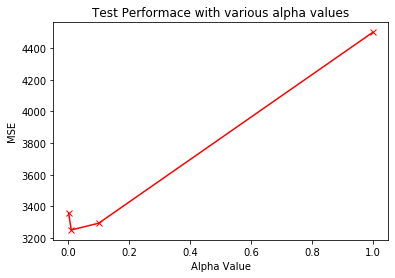

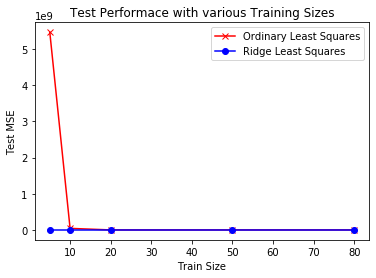

In [1670]:
# for part (b)

# alpha plots 
alphas = [0.001, 0.01, 0.1, 1]  # alphas to use
mses = []  # array to store test mse values
num_trials = 50  # num trials for each alpha

for alpha in alphas:
    mse = 0
    for i in range(num_trials):
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=80)

        # train theta
        LS = MyRidgeLeastSquares(X_train, y_train, alpha=alpha)
        LS.fit()

        # test
        y_pred = LS.predict(X_test)
        
        mse += np.sum((y_pred - y_test)**2)/y_pred.size
    
    mses.append(mse/num_trials)
    
plt.plot(alphas, mses, marker='x', color='r')
plt.xlabel('Alpha Value')
plt.ylabel('MSE')
plt.title('Test Performace with various alpha values')
plt.show()

# train size plots
train_sizes = [5, 10, 20, 50, 80]  # alphas to use
mses_ols = []  # array to store test mse values for ordinary least squares
mses_rls = []  # array to store test mse values for ridge least squares
num_trials = 50  # num trials for each alpha

for n_train in train_sizes:
    mse_ols = 0
    mse_rls = 0
    for i in range(num_trials):
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train)
        
        # train theta using ols
        LS = MyLeastSquares(X_train, y_train)
        LS.fit()
        
        # train theta using rls
        RLS = MyRidgeLeastSquares(X_train, y_train, alpha=0.1)
        RLS.fit()

        # test
        y_pred_ls = LS.predict(X_test)
        y_pred_rls = RLS.predict(X_test)
        
        mse_ols += np.sum((y_pred_ls - y_test)**2)/y_pred.size
        mse_rls += np.sum((y_pred_rls - y_test)**2)/y_pred.size
    
    mses_ols.append(mse_ols/num_trials)
    mses_rls.append(mse_rls/num_trials)
    
plt.plot(train_sizes, mses_ols, marker='x', color='r', label='Ordinary Least Squares')
plt.plot(train_sizes, mses_rls, marker='o', color='b', label='Ridge Least Squares')
plt.xlabel('Train Size')
plt.ylabel('Test MSE')
plt.title('Test Performace with various Training Sizes')
plt.legend()
plt.show()

**_Solution to (b)_**

Clearly, ridge penalty has a regularizing effect at an intermediate value. If it is too less, it reduces to the case of ordinary least squares. Too much and it leads to underfitting of training data. It is also observed that Ridge Least Squares performs much better compared to Ordinary least squares for very limited data sizes. For larger data sizes, OLS is able to catch up pretty well to RLS.

In [416]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

class MyLassoLeastSquares:
    def __init__(self, X_train, y_train, beta=0):
        """Function stores feature matrix and corresponding target data.
        
        Parameters:
        -----------
        X_train: array_like, shape(N,D)
            ndarray containing N training examples, each with D feature values.
            
        y_train: array_like, shape(N,1)
            ndarray containing target values for each of N examples in X_train.
        
        beta: float
            float specifying the multiplier of the L1 penalty in Ridge loss"""
        
        self.X_train = X_train
        self.y_train = y_train
        self.beta = beta
        self.theta = np.random.randn(X_train.shape[1]+1, 1)
        
    def gradient(self, X):
        """Function computes gradient of Lasso cost.
        
        Parameters:
        -----------
        X: array_like, shape(N, D+1)
            feature matrix containing N training examples containing D+1 features each
        
        Returns:
        --------
        grad = array_like, shape(D+1, 1).
            gradient vector containing gradient for each element in theta vector.
        """
        
        lasso_grad = np.ones(self.theta.shape)
        lasso_grad[self.theta<=0] = -1
        grad = (2*X.T.dot(X.dot(self.theta) - self.y_train.reshape(-1,1)))/X.shape[0] + self.beta*lasso_grad
        
        return grad
        
    
    def fit(self, num_epochs, step):
        """Function computes the weight vector of shape (D+1, 1) for regression.
        
        Parameters:
        -----------
        num_epochs: int,
            integer specifying number of trianing epochs
            
        step: float
            float specifying step size for gradient descent
        """
                
        # append ones for bias
        X = np.concatenate((self.X_train, np.ones((self.X_train.shape[0],1))), axis=1)
        
        # warm start
        self.theta = np.linalg.inv(X.T.dot(X) + 0.0*np.eye(X.shape[1])).dot(X.T.dot(self.y_train)).reshape(-1,1)
        
        for i in range(num_epochs):
            cost = np.sum((y_train-X.dot(self.theta))**2)/X.shape[0] + self.beta*np.sum(np.abs(self.theta))
#             self.theta = self.theta - step*self.gradient(X) # simple gradient descent
            
            
#             for j in range(self.theta.size):
#                 self.theta[j] = self.theta[j] - step*self.gradient(X)[j]                                  # coordinate descent
                
            self.theta = self.theta - step*np.linalg.inv(2/X.shape[0] * X.T.dot(X)).dot(self.gradient(X))  # newton's method
            
            if i%50==0:
                print('Cost: {:0.3f} | theta norm: {:0.3f}'.format(cost, np.linalg.norm(self.theta)))

                
                
    def predict(self, X_test):
        """Function predicts targets for given X_test.
        
        Parameters:
        -----------
        X_test: array_like, shape(N,D)
            ndarray containing N test examples with D features each.
            
        Returns: array_like, shape(N,1).
            ndarray containing predicted targets of shape (N,1).
        """
        
        X = np.concatenate((X_test, np.ones((X_test.shape[0],1))), axis=1)
        y_pred = X.dot(self.theta)
        
        return y_pred
    
# load dataset
diabetes = load_boston()
X, y = diabetes.data, diabetes.target

# train-test split
n_train = 20
n_test = X.shape[0] - n_train

# perform rank truncation
rank = np.linalg.matrix_rank(X)
X = rank_truncate(X, rank)

# normalize X
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True) 
y = (y - y.mean()) / y.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)

#train theta
LS = MyLassoLeastSquares(X_train, y_train, beta=0.1)
LS.fit(num_epochs=2000, step=0.1)

# LS = MyLeastSquares(X_train, y_train)
# LS.fit()

# test
y_pred = LS.predict(X_test)

# evaluate performance
print('MSE on Training Data: {:0.3f}'.format(np.sum((LS.predict(X_train) - y_train)**2)/y_train.size))
print('MSE on Test Data: {:0.3f}'.format(np.sum((y_pred - y_test)**2)/y_pred.size))



Cost: 54.653 | theta norm: 1.119
Cost: 50.950 | theta norm: 0.801
Cost: 50.654 | theta norm: 0.804
Cost: 50.919 | theta norm: 0.838
Cost: 50.874 | theta norm: 0.986
Cost: 50.996 | theta norm: 0.960
Cost: 50.839 | theta norm: 0.888
Cost: 50.676 | theta norm: 0.951
Cost: 50.790 | theta norm: 0.789
Cost: 50.922 | theta norm: 0.828
Cost: 50.881 | theta norm: 0.865
Cost: 50.865 | theta norm: 0.864
Cost: 50.896 | theta norm: 0.864
Cost: 50.848 | theta norm: 0.784
Cost: 50.767 | theta norm: 0.819
Cost: 50.611 | theta norm: 0.983
Cost: 50.757 | theta norm: 0.829
Cost: 50.750 | theta norm: 0.888
Cost: 50.781 | theta norm: 0.857
Cost: 50.941 | theta norm: 0.956
Cost: 50.945 | theta norm: 0.979
Cost: 50.783 | theta norm: 0.834
Cost: 50.954 | theta norm: 0.881
Cost: 50.761 | theta norm: 0.895
Cost: 50.697 | theta norm: 0.932
Cost: 50.743 | theta norm: 0.960
Cost: 50.762 | theta norm: 0.969
Cost: 50.878 | theta norm: 0.847
Cost: 51.174 | theta norm: 0.966
Cost: 50.656 | theta norm: 0.869
Cost: 50.9

In [67]:
from sklearn.datasets import load_linnerud
from sklearn.model_selection import train_test_split

def gen_polynomial_features(X, power):
    """Function generates polynomial features of specified power and appends to X.
    
    Parameters:
    -----------
    X: array_like, shape(N,D).
        ndarray of feature matrix containing N training examples with D features each.
        
    power: int
        integer specifying power X is raised to before appended to itself.
    
    Returns:
    --------
    X_poly: array_like, shape(N,2D)
        ndarray of appended polynomial features to original feature matrix"""
    
    X_poly = np.concatenate((X, X**power), axis=1)
    
    return X_poly
    
# load dataset
exercises = load_linnerud()
X, y = exercises.data, exercises.target[:,0]

# train-test split
n_train = 3
n_test = X.shape[0] - n_train

#generate polynomial features
#X = gen_polynomial_features(X, power=2)

# perform rank truncation
rank = np.linalg.matrix_rank(X)
X = rank_truncate(X, rank)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=4803)

# train theta
LS = MyLeastSquares(X_train, y_train)
LS.fit()

# test
y_pred = LS.predict(X_test)

# evaluate performance
print('MSE on Training Data: {:0.3f}'.format(np.sum((LS.predict(X_train) - y_train)**2)/y_train.size))
print('MSE on Test Data: {:0.3f}'.format(np.sum((y_pred - y_test)**2)/y_pred.size))



MSE on Training Data: 870.333
MSE on Test Data: 2417.588
